In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hadicanmunis","key":"b44a2eb3779ffb94c073015c60c0ad77"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d hadicanmunis/plantvillage-original

100% 355M/355M [00:12<00:00, 38.9MB/s]
100% 355M/355M [00:12<00:00, 28.9MB/s]


In [4]:
!unzip -qq plantvillage-original.zip

In [5]:
import os, shutil, pathlib
import numpy as np
import tensorflow as tf
import keras
import pandas as pd
from keras import layers
import matplotlib.pyplot as plt

In [6]:
dataset_dir = pathlib.Path("/content/Plant_leave_diseases_dataset_without_augmentation")

In [7]:
lst = os.listdir(dataset_dir)
lst.sort()
lst

['Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [9]:
from tensorflow.keras.utils import image_dataset_from_directory

train_ds, val_ds = image_dataset_from_directory(
    dataset_dir,
    label_mode="categorical",
    batch_size=64,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0.3,
    subset="both",
)

Found 22787 files belonging to 15 classes.
Using 15951 files for training.
Using 6836 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [11]:
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels.shape)
    break

(64, 256, 256, 3)
(64, 15)


In [12]:
for images, labels in val_ds.take(1):
    print(images.shape)
    print(labels.shape)
    break

(64, 256, 256, 3)
(64, 15)


In [13]:
tf.data.experimental.cardinality(train_ds)

<tf.Tensor: shape=(), dtype=int64, numpy=250>

In [14]:
tf.data.experimental.cardinality(val_ds)

<tf.Tensor: shape=(), dtype=int64, numpy=107>

In [15]:
test_ds = val_ds.take(53)
val_ds = val_ds.skip(53)

In [16]:
tf.data.experimental.cardinality(val_ds)

<tf.Tensor: shape=(), dtype=int64, numpy=54>

In [17]:
tf.data.experimental.cardinality(test_ds)

<tf.Tensor: shape=(), dtype=int64, numpy=53>

In [18]:
conv_base = keras.applications.Xception(
    weights="imagenet",
    include_top=False,
    input_shape=(256, 256, 3))

conv_base.trainable = False

83683744/83683744 [==============================] - 3s 0us/step


In [19]:
conv_base.trainable = True
print("This is the number of trainable weights "
          "before freezing the conv base:", len(conv_base.trainable_weights))

conv_base.trainable = False
print("This is the number of trainable weights "
          "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 154
This is the number of trainable weights after freezing the conv base: 0


In [20]:
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 127, 127, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 127, 127, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 127, 127, 32)         0         ['block1_conv1_bn[0][0]

In [51]:
from tensorflow import keras
from keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.4),
        layers.RandomZoom(0.2),
        layers.RandomBrightness(0.25),
        layers.RandomContrast(0.1)
    ]
)

inputs = keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = keras.applications.xception.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(15, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              metrics=["accuracy"])

In [52]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv_4 (TFOpLam  (None, 256, 256, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_4 (TFOpLa  (None, 256, 256, 3)       0         
 mbda)                                                           
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 flatten_4 (Flatten)         (None, 131072)            0   

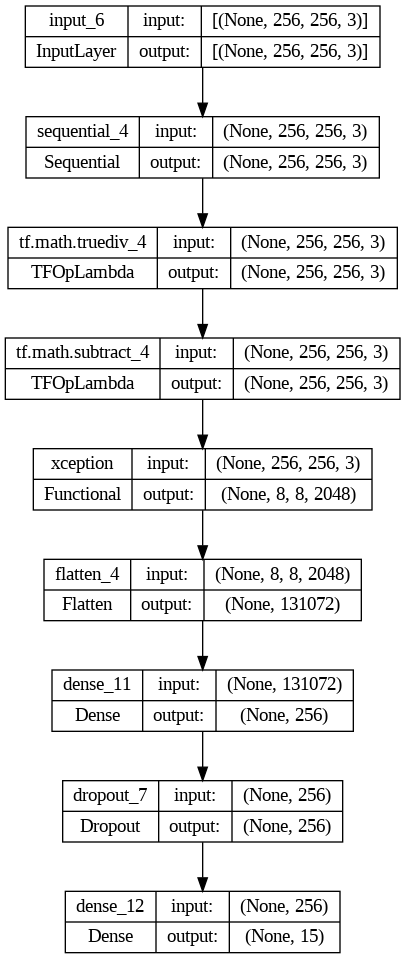

In [53]:
keras.utils.plot_model(model, show_shapes=True)

In [54]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="model_xception_finetuned.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=callbacks)

Epoch 1/100
250/250 [==============================] - 43s 156ms/step - loss: 1.0433 - accuracy: 0.6685 - val_loss: 0.7361 - val_accuracy: 0.7584
Epoch 2/100
250/250 [==============================] - 38s 153ms/step - loss: 0.6338 - accuracy: 0.7920 - val_loss: 0.6316 - val_accuracy: 0.7886
Epoch 3/100
250/250 [==============================] - 38s 151ms/step - loss: 0.5374 - accuracy: 0.8203 - val_loss: 0.5516 - val_accuracy: 0.8188
Epoch 4/100
250/250 [==============================] - 38s 152ms/step - loss: 0.4797 - accuracy: 0.8413 - val_loss: 0.4751 - val_accuracy: 0.8481
Epoch 5/100
250/250 [==============================] - 38s 152ms/step - loss: 0.4611 - accuracy: 0.8499 - val_loss: 0.4396 - val_accuracy: 0.8539
Epoch 6/100
250/250 [==============================] - 36s 143ms/step - loss: 0.4231 - accuracy: 0.8592 - val_loss: 0.4606 - val_accuracy: 0.8452
Epoch 7/100
250/250 [==============================] - 39s 154ms/step - loss: 0.4105 - accuracy: 0.8630 - val_loss: 0.4352 -

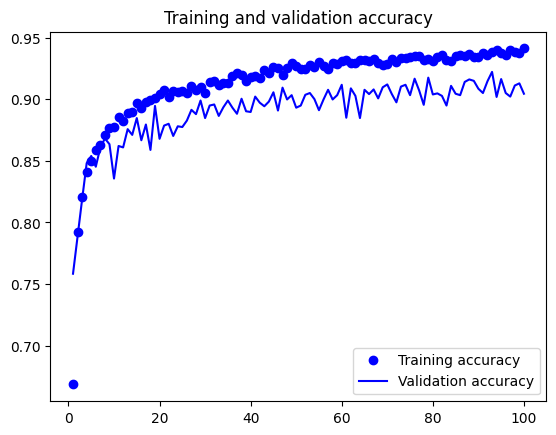

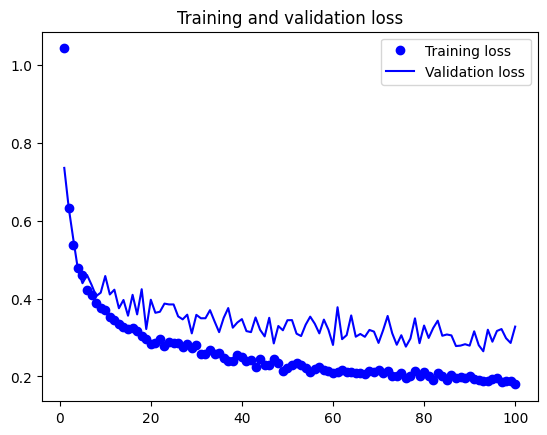

In [55]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [56]:
test_model = keras.models.load_model("model_xception_finetuned.keras")
test_loss, test_acc = test_model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

53/53 [==============================] - 7s 108ms/step - loss: 0.2437 - accuracy: 0.9245
Test accuracy: 0.925


In [57]:
y_pred = test_model.predict(test_ds)
predicted_labels = np.argmax(y_pred, axis=1)

53/53 [==============================] - 7s 105ms/step


In [58]:
true_categories = tf.concat([y for x, y in test_ds], axis=0)
y_true = np.argmax(true_categories, axis=1)

In [59]:
y_true.tolist()

[14,
 12,
 2,
 12,
 12,
 12,
 0,
 11,
 2,
 9,
 5,
 5,
 12,
 6,
 5,
 3,
 2,
 10,
 2,
 5,
 9,
 14,
 11,
 1,
 9,
 3,
 7,
 12,
 11,
 12,
 3,
 5,
 9,
 9,
 3,
 2,
 2,
 11,
 10,
 12,
 3,
 7,
 14,
 8,
 7,
 3,
 12,
 12,
 12,
 2,
 14,
 11,
 5,
 2,
 7,
 6,
 12,
 2,
 11,
 0,
 12,
 10,
 11,
 12,
 5,
 2,
 9,
 5,
 11,
 1,
 10,
 3,
 12,
 8,
 10,
 12,
 5,
 10,
 5,
 9,
 12,
 2,
 6,
 12,
 11,
 11,
 3,
 8,
 12,
 8,
 5,
 10,
 7,
 2,
 14,
 12,
 9,
 5,
 7,
 12,
 9,
 12,
 7,
 11,
 5,
 10,
 14,
 6,
 3,
 0,
 12,
 9,
 13,
 10,
 11,
 12,
 12,
 10,
 11,
 12,
 12,
 12,
 5,
 8,
 7,
 12,
 12,
 5,
 7,
 2,
 9,
 9,
 12,
 9,
 12,
 5,
 6,
 2,
 14,
 12,
 4,
 2,
 2,
 8,
 5,
 0,
 12,
 14,
 11,
 1,
 12,
 9,
 10,
 14,
 1,
 12,
 6,
 10,
 12,
 0,
 12,
 0,
 12,
 9,
 9,
 0,
 6,
 5,
 7,
 9,
 2,
 14,
 12,
 13,
 10,
 12,
 5,
 14,
 9,
 1,
 14,
 12,
 5,
 14,
 6,
 14,
 2,
 10,
 7,
 10,
 8,
 12,
 0,
 7,
 5,
 9,
 9,
 9,
 8,
 5,
 11,
 12,
 0,
 7,
 7,
 12,
 12,
 1,
 10,
 8,
 8,
 9,
 8,
 12,
 8,
 5,
 6,
 2,
 0,
 5,
 10,
 12,
 7,
 1,
 8,
 12,

In [60]:
predicted_labels.tolist()

[14,
 12,
 2,
 12,
 12,
 12,
 0,
 11,
 3,
 9,
 5,
 5,
 12,
 6,
 5,
 3,
 2,
 10,
 2,
 5,
 9,
 14,
 11,
 1,
 9,
 3,
 7,
 12,
 11,
 12,
 3,
 5,
 9,
 9,
 3,
 2,
 2,
 11,
 10,
 12,
 3,
 7,
 11,
 8,
 7,
 3,
 12,
 12,
 12,
 2,
 14,
 11,
 5,
 2,
 7,
 7,
 12,
 2,
 11,
 0,
 12,
 10,
 11,
 12,
 5,
 2,
 9,
 5,
 10,
 1,
 10,
 3,
 12,
 8,
 10,
 12,
 5,
 10,
 5,
 9,
 12,
 2,
 6,
 12,
 11,
 11,
 3,
 8,
 12,
 8,
 5,
 11,
 7,
 2,
 14,
 12,
 9,
 5,
 7,
 12,
 9,
 12,
 7,
 11,
 5,
 10,
 14,
 6,
 3,
 0,
 12,
 9,
 13,
 10,
 11,
 12,
 12,
 10,
 11,
 12,
 12,
 12,
 5,
 8,
 7,
 12,
 12,
 5,
 7,
 2,
 9,
 9,
 12,
 9,
 12,
 5,
 6,
 2,
 14,
 12,
 4,
 2,
 2,
 8,
 5,
 0,
 12,
 14,
 11,
 0,
 12,
 9,
 11,
 14,
 1,
 12,
 6,
 10,
 12,
 0,
 12,
 0,
 12,
 9,
 9,
 0,
 11,
 5,
 7,
 9,
 2,
 14,
 12,
 13,
 10,
 12,
 5,
 14,
 9,
 1,
 14,
 12,
 5,
 14,
 9,
 14,
 2,
 13,
 7,
 6,
 8,
 12,
 0,
 7,
 5,
 9,
 11,
 11,
 8,
 5,
 11,
 12,
 0,
 7,
 7,
 12,
 12,
 1,
 10,
 8,
 8,
 9,
 8,
 12,
 8,
 5,
 6,
 2,
 0,
 5,
 10,
 12,
 7,
 1,
 6,
 1

In [61]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_true, predicted_labels)

In [62]:
print(classification_report(y_true, predicted_labels, target_names = class_names))

                                               precision    recall  f1-score   support

                Pepper,_bell___Bacterial_spot       0.94      0.95      0.94       141
                       Pepper,_bell___healthy       0.98      0.99      0.98       205
                        Potato___Early_blight       1.00      0.95      0.97       157
                         Potato___Late_blight       0.90      0.91      0.90       138
                             Potato___healthy       0.96      0.88      0.92        26
                      Tomato___Bacterial_spot       0.93      0.91      0.92       298
                        Tomato___Early_blight       0.79      0.73      0.76       169
                         Tomato___Late_blight       0.90      0.90      0.90       292
                           Tomato___Leaf_Mold       0.95      0.90      0.93       132
                  Tomato___Septoria_leaf_spot       0.86      0.90      0.88       270
Tomato___Spider_mites Two-spotted_spider_m

<Axes: >

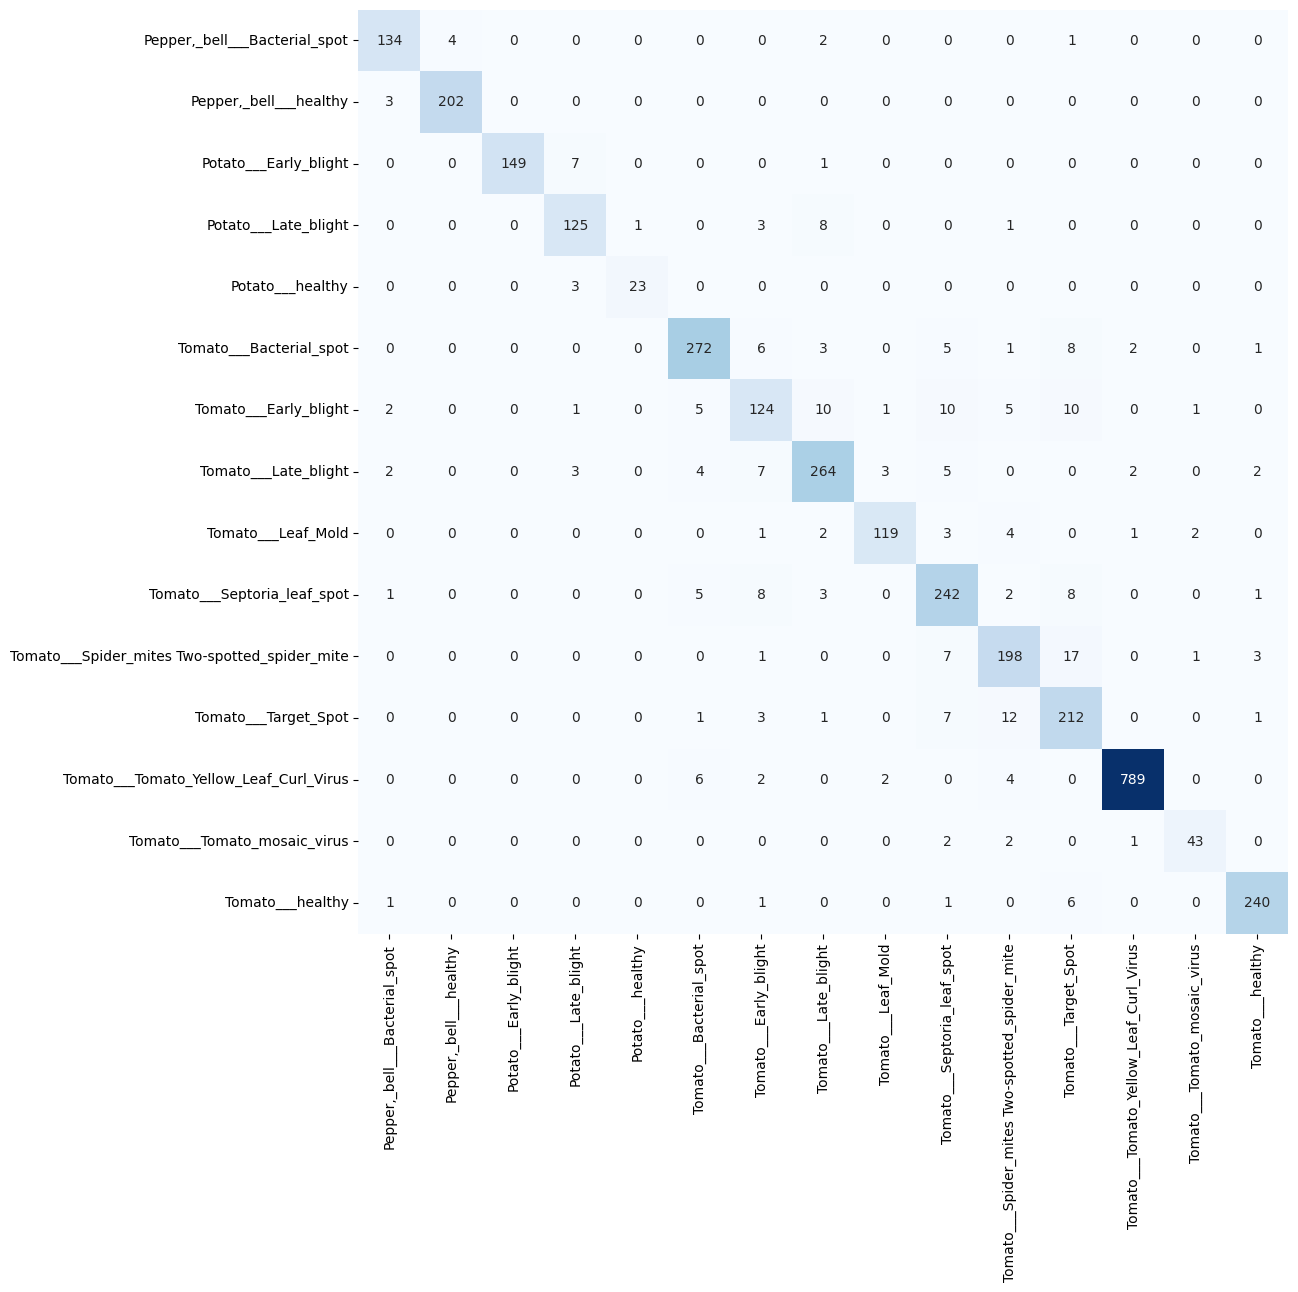

In [63]:
import seaborn as sns

plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt="d", cbar=False, cmap="Blues", xticklabels=train_ds.class_names, yticklabels=train_ds.class_names)

In [90]:
image_path = "/content/20240412_164746.jpg"

img = tf.keras.utils.load_img(
    image_path, target_size=(256, 256)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 26ms/step
This image most likely belongs to Tomato___Early_blight with a 10.89 percent confidence.


In [91]:
score

<tf.Tensor: shape=(15,), dtype=float32, numpy=
array([0.06178093, 0.06165553, 0.06170262, 0.06177216, 0.06166798,
       0.06163583, 0.1088542 , 0.07432491, 0.06227912, 0.06255452,
       0.06753372, 0.06227577, 0.06173366, 0.06818411, 0.0620449 ],
      dtype=float32)>

In [92]:
image_path = "/content/20240412_164746.jpg"

img = tf.keras.utils.load_img(
    image_path, target_size=(256, 256)
)
img=np.expand_dims(img, axis=0)
print ('image shape after expanding dimensions is ',img.shape)
pred=model.predict(img)
print (' the shape of prediction is ', pred.shape)
index=np.argmax(pred[0])
klass=class_names[index]
probability=pred[0][index]*100
print('the image is predicted as being ', klass, ' with a probability of', probability)

image shape after expanding dimensions is  (1, 256, 256, 3)
1/1 [==============================] - 0s 22ms/step
 the shape of prediction is  (1, 15)
the image is predicted as being  Tomato___Early_blight  with a probability of 56.88651204109192


In [93]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)